### Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from imageio import imread, imsave
import cv2

# Problem 1

Know $x_c, y_c, x_s, y_s, r$ and $z_c=1$ from the camera's look-at vector. Want to find $z_s$.

$$
\begin{align}
(x_s - x_c)^2 + (y_s - y_c)^2 + (z_s - z_c)^2 = r^2 \\
(z_s - 1)^2 = r^2 - (x_s - x_c)^2 - (y_s - y_c)^2 \\
z_s = \sqrt{r^2 - (x_s - x_c)^2 - (y_s - y_c)^2} + 1
\end{align}
$$

Hence, the direction of the light source, $(x_s, y_s, z_s)$ is:
$$(x_s, y_s, \sqrt{r^2 - (x_s - x_c)^2 - (y_s - y_c)^2} + 1)$$

# 2. Photometric Stereo

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

def plot_normal_map(normal_map):
    normal_viz = normal_map[:, ::, :]

    normal_viz = normal_viz + np.equal(np.sum(normal_viz, 2, 
    keepdims=True), 0.).astype(np.float32)*np.min(normal_viz)

    normal_viz = (normal_viz - np.min(normal_viz))/2.
    plt.axis('off')
    plt.imshow(normal_viz)

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

#### Plot the albedo and the surface norms. 

In [4]:
def plot_albedo_and_surface_normals(albedo_image, surface_normals):
    """
    albedo_image: h x w matrix
    surface_normals: h x w x 3 matrix.
    """
    fig, axes = plt.subplots(1, 4, figsize=(10,2.5))
    ax = axes[0]
    ax.axis('off')
    ax.set_title('albedo')
    ax.imshow(albedo_image, cmap='gray')

    ax = axes[1]
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0], cmap='jet')
    ax = axes[2]
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1], cmap='jet')
    ax = axes[3]
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2], cmap='jet')

    fig.colorbar(im, ax=axes, fraction=0.02, aspect=15)

#### Plot the height map

In [5]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

def display_3d(albedo_image, height_map, elev=20, azim=20):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(elev, azim)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

---
### Your implementation

## Problem 2

In [6]:
yale_subjects = ['yaleB01', 'yaleB02', 'yaleB05', 'yaleB07']
yale = {}

for subject in yale_subjects:
    ambimage, imarray, lightdirs = LoadFaceImages(
        'data/croppedyale/' + subject, subject, 64)
    yale[subject] = {
        'ambimage': ambimage,
        'imarray': imarray,
        'lightdirs': lightdirs
    }

I picked the first subject, yaleB01. The shadows fall on different parts of the subject's face and reveal information about the shape of the parts in images with different lighting directions. For example, from the second image below, the bottom of the nose is lightened up while the nose bridge is in shadows when the light comes from the bottom.

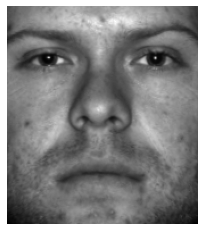

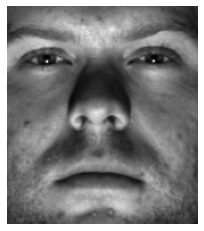

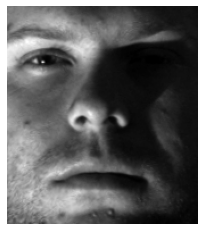

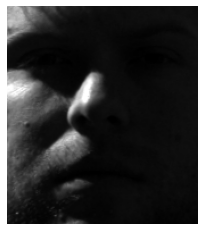

In [7]:
for i in [0, 5, 20, 30]:
    plt.imshow(yale['yaleB01']['imarray'][:, :, i], cmap='gray')
    plt.axis('off')
    plt.show()

## Problem 3

In [8]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    processed = imarray - ambimage[:, :, np.newaxis]
    processed = np.where(processed < 0, 0, processed).astype(float)
    processed /= 255
    return processed

In [9]:
for subject in yale_subjects:
    processed = preprocess(
        yale[subject]['ambimage'],
        yale[subject]['imarray']
    )
    yale[subject]['processed'] = processed

The preprocessed images don't look too different from the ones we showed above.

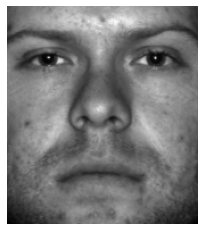

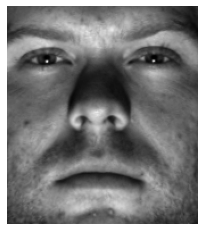

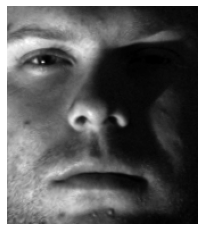

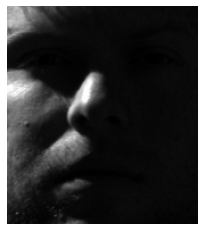

In [10]:
for i in [0, 5, 20, 30]:
    plt.imshow(yale['yaleB01']['processed'][:, :, i], cmap='gray')
    plt.axis('off')
    plt.show()

## Problem 4

In [11]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    height, width = imarray.shape[:2]
    albedo_image = np.empty((height, width))
    surface_norms = np.empty((height, width, 3))
    for h in range(height):
        for w in range(width):
            intensity = imarray[h, w, :] # Nx1
            G = np.linalg.lstsq(light_dirs, intensity, rcond=None)[0]
            albedo = np.linalg.norm(G)
            albedo_image[h, w] = albedo
            surface_norms[h, w] = G / albedo
    return albedo_image, surface_norms

In [12]:
for subject in yale_subjects:
    albedo_image, surface_norms = photometric_stereo(
        yale[subject]['processed'],
        yale[subject]['lightdirs']
    )
    yale[subject]['albedo'] = albedo_image
    yale[subject]['surface_norms'] = surface_norms

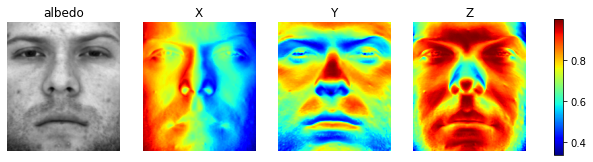

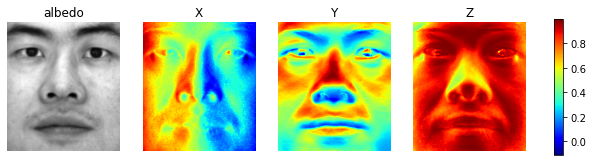

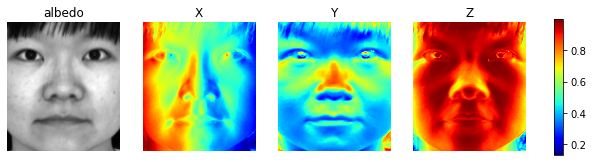

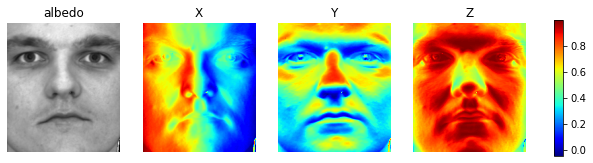

In [13]:
for subject in yale_subjects:
    plot_albedo_and_surface_normals(
        yale[subject]['albedo'],
        yale[subject]['surface_norms']
    )

## Problem 5

$$
f(x, y) = \sum_{s=0}^{x} f_x(s, 0) + \sum_{t=0}^y f_y(x, t)
$$

In [14]:
def get_surface(surface_normals):
    """
    Inputs:
        surface_normals:h x w x 3
    Outputs:
        height_map: h x w
    """
    height, width = surface_normals.shape[:2]
    height_map = np.empty((height, width))
    f_x = surface_normals[:, :, 0] / surface_normals[:, :, 2]
    f_y = surface_normals[:, :, 1] / surface_normals[:, :, 2]
    
    # row then column
    f_x_sum = 0 # cache computations
    for w in range(width):
        f_y_sum = 0
        f_x_sum += f_x[0, w]
        for h in range(height):
            f_y_sum += f_y[h, w]
            height_map[h, w] = f_x_sum + f_y_sum
    return height_map

In [15]:
for subject in yale_subjects:
    height_map = get_surface(yale[subject]['surface_norms'])
    yale[subject]['height_map'] = height_map

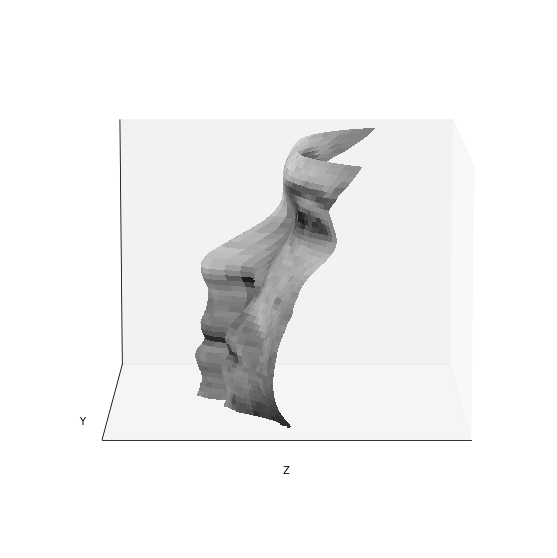

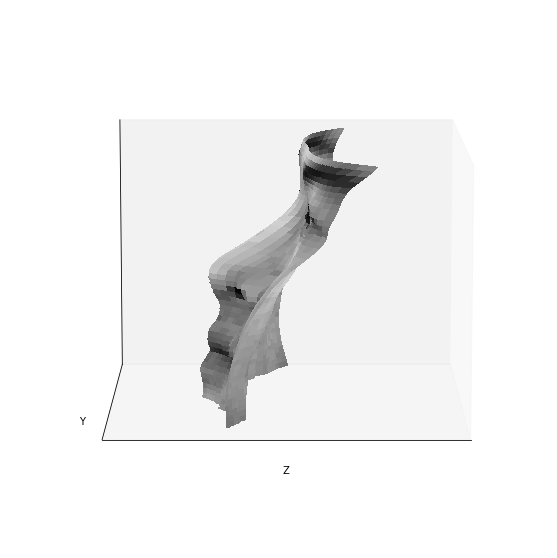

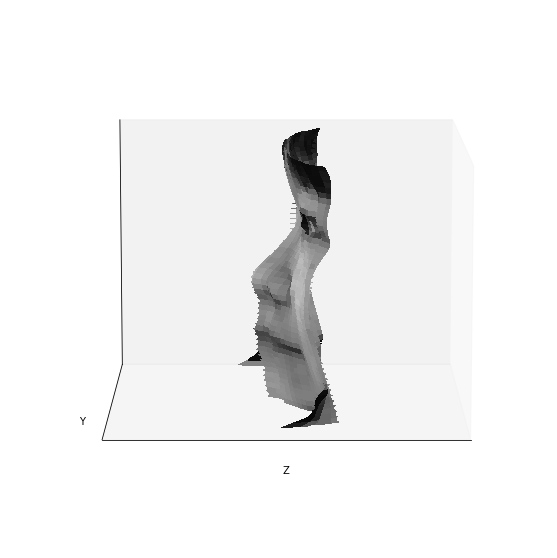

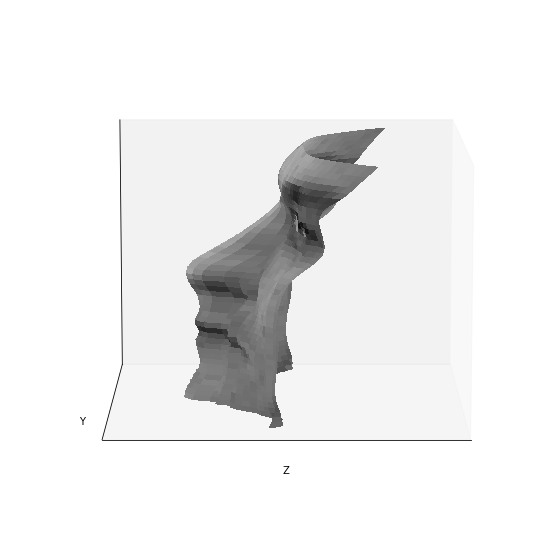

In [16]:
for subject in yale_subjects:
    display_3d(
        yale[subject]['albedo'],
        yale[subject]['height_map'],
        elev=10, azim=90
    )

### Main function

'\nif save_flag:\n    save_outputs(subject_name, albedo_image, surface_normals)\n'

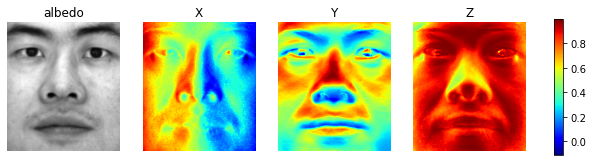

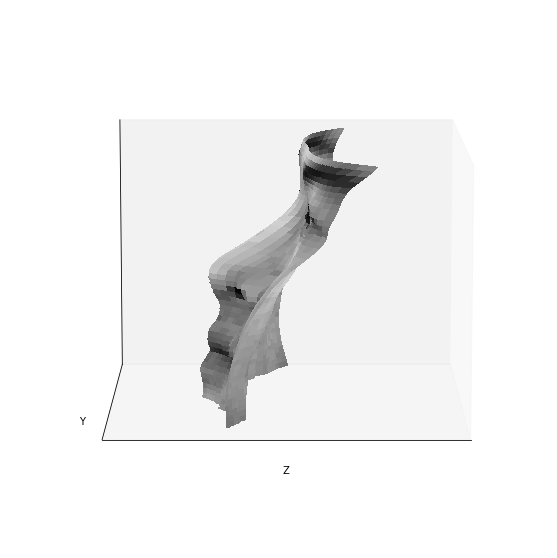

In [17]:
root_path = 'data/croppedyale/'
subject_name = 'yaleB02'

integration_method = 'average'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)


processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)


height_map = get_surface(surface_normals)

plot_albedo_and_surface_normals(albedo_image, surface_normals)
display_3d(albedo_image, height_map, elev=10, azim=90)
"""
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)
"""

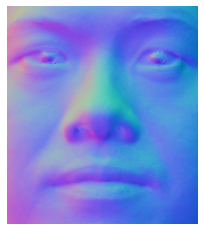

In [18]:
plot_normal_map(surface_normals)

## Problem 6

# 3. Denoising

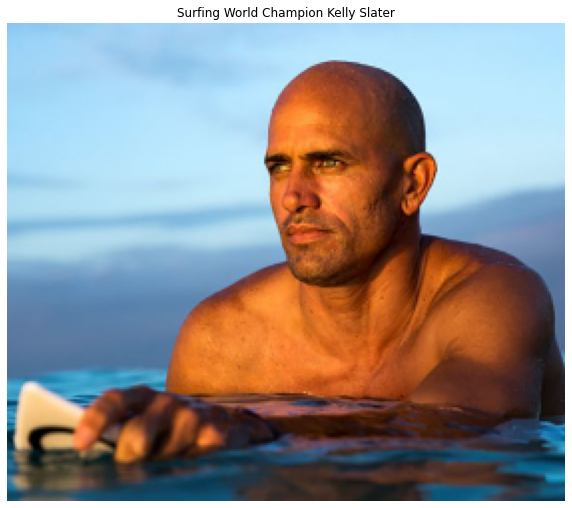

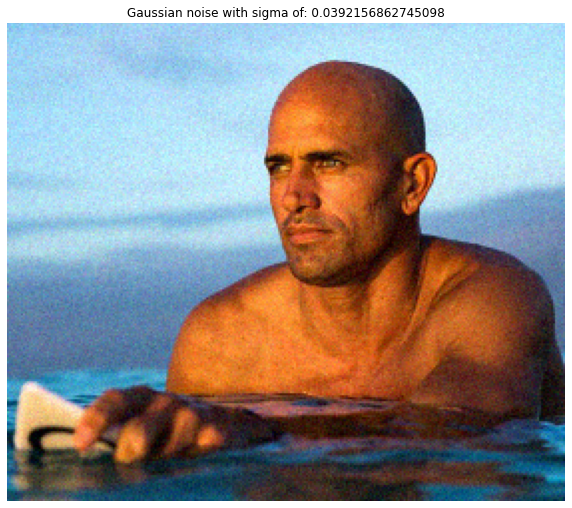

In [ ]:
slater_image = imread('data/slater.jpg')/255.

# Note: we are reducing the size for faster processing.
slater_image = cv2.resize(slater_image, (280, 240))

sigma = 10/255.

plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(slater_image)

def noising_model(image, sigma):
    noise = np.random.normal(0, sigma, (image.shape))
    return image + noise

noisy_image = noising_model(slater_image, sigma=sigma)

# need to bring us better into range
noisy_image = np.clip(noisy_image, 0, 1)

plt.title("Surfing World Champion Kelly Slater")
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Gaussian noise with sigma of: {}".format(sigma))
plt.imshow(noisy_image)

# "real" noise image
chess_raw = imread("data/chess.png")

chess_noisy = cv2.resize(chess_raw, (int(chess_raw.shape[1]/4), int(chess_raw.shape[0]/4)))/255.
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Low-light smartphone image")
plt.imshow(chess_noisy)

## Problem 7 and 8

In [ ]:
# Implement the two filters from scratch

def median_filter(data, filter_size):
    pass

def mean_filter(data, filter_size):
    pass

In [ ]:
window_size = 5

mean_filtered_image = mean_filter(noisy_image, window_size)
median_filtered_image = median_filter(noisy_image, window_size)

plt.figure(figsize=(10,20))
plt.title("Noisy image")
plt.imshow(noisy_image)
plt.axis('off')
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Mean filtering with window size: {}".format(window_size))
plt.imshow(mean_filtered_image)
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Median filtering with window size: {}".format(window_size))
plt.imshow(median_filtered_image)

## Problem 9

In [ ]:
def psnr(noisy_image, denoised_image):
    pass

def mse(noisy_image, denoised_image):
    pass

In [ ]:
print("PSNR for the noisy image: {}".format(psnr(slater_image, noisy_image)))
print("PSNR for the mean filtered image: {}".format(psnr(slater_image, mean_filtered_image)))
print("PSNR for the median filtered image: {}".format(psnr(slater_image, median_filtered_image)))

## Problem 10 and 11

In [ ]:
def compute_weight(d, h=1, sigma=20/255.):
    pass

def bilateral_filter(image, sigma=None, h=None):
    
    # hint for "naive" for-loop based implementation
    
    n1, n2, c = image.shape

    Z = np.zeros((n1, n2, *[1] * (image.ndim - 2)))
    x = np.zeros(image.shape)

    s1 = s2 = 2 # search window domain
    p1 = p2 = 1 # patch domain; patch size is (2p1 + 1) x (2p2 + 1)

    for i in range(s1, n1-s1-p1):
        for j in range(s2, n2-s2-p2):
                for k in range(-s1, s1 + 1):
                    for l in range(-s2, s2 + 1):
                        pass

In [ ]:
def nlmeans_filter(image, sigma=None, h=None):
    # hint: implementation will be very similar to bilateral filter
    # can reuse most of your implementation
    pass

In [ ]:
import time

start = time.time()

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("noisy")
plt.imshow(noisy_image)

bilateral_filtered_image = bilateral_filter(noisy_image, sigma=10/255.)
nlmeans_filtered_image = nlmeans_filter(noisy_image, sigma=10/255.)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Bilateral filtered")
plt.imshow(bilateral_filtered_image)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("NLM filtered")
plt.imshow(nlmeans_filtered_image)

elapsed = (time.time() - start)

hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)
print(minutes, seconds)

# Note: your numbers can be different depending on implementation and hyperparameters
print("PSNR for the bilateral filtered image: {}".format(psnr(slater_image, bilateral_filtered_image)))
print("PSNR for the NLM filtered image: {}".format(psnr(slater_image, nlmeans_filtered_image)))

In [ ]:
# Example of denoising for the chess image with unknown noise.  Feel free to play with the sigma "guess"
# and other parameters to see if you can improve the qualitative reconstruction
# Reducing the size of the image for faster processing

chess_raw = imread("data/chess.png")

chess_noisy = cv2.resize(chess_raw, (int(chess_raw.shape[1]/4), int(chess_raw.shape[0]/4)))/255.
plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Low-light smartphone image")
plt.imshow(chess_noisy)

mean_filtered_chess = mean_filter(chess_noisy, 3)
bilateral_filtered_chess_20 = bilateral_filter(chess_noisy, sigma=20/255.)
bilateral_filtered_chess_40 = bilateral_filter(chess_noisy, sigma=40/255.)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Mean filtered image")
plt.imshow(mean_filtered_chess)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Bilateral filtered image (sigma=20/255)")
plt.imshow(bilateral_filtered_chess_20)

plt.figure(figsize=(10,20))
plt.axis('off')
plt.title("Bilateral filtered image (sigma=40/255)")
plt.imshow(bilateral_filtered_chess_40)